In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

2025-09-20 01:55:27.957739: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-20 01:55:27.967170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758347727.978819  331222 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758347727.982432  331222 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-20 01:55:27.993740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
path = os.environ["DATA_PATH"]
files = os.listdir(path)
csv_files = [f for f in files if f.endswith('.csv')]

if csv_files:
    # Load the first CSV file found
    csv_file = csv_files[0]
    csv_path = os.path.join(path, csv_file)
    df = pd.read_csv(csv_path)
    print(f"Loaded {csv_file}")
    print(df.head())

Loaded Student_Performance.csv
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  


In [3]:
#  Basic cleaning / column selection
target = "Performance Index"
feature_names = [
    "Hours Studied",
    "Previous Scores",
    "Extracurricular Activities",   # often 0/1
    "Sleep Hours",
    "Sample Question Papers Practiced"
]
X = df[feature_names].copy()
y = df[target].astype(float)

# If Extracurricular Activities is 'Yes'/'No', convert to 1/0:
if X["Extracurricular Activities"].dtype == object:
    X["Extracurricular Activities"] = X["Extracurricular Activities"].str.strip().str.lower().map({"yes":1, "no":0})

In [4]:
# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X.values, y.values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train) # fit on train only

I0000 00:00:1758347730.146799  331222 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


I0000 00:00:1758347731.120238  331387 service.cc:148] XLA service 0x76359c005500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758347731.120282  331387 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-09-20 01:55:31.129491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758347731.153684  331387 cuda_dnn.cc:529] Loaded cuDNN version 90101
I0000 00:00:1758347731.277014  331387 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/tmp/ipykernel_331222/2867436087.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  retu

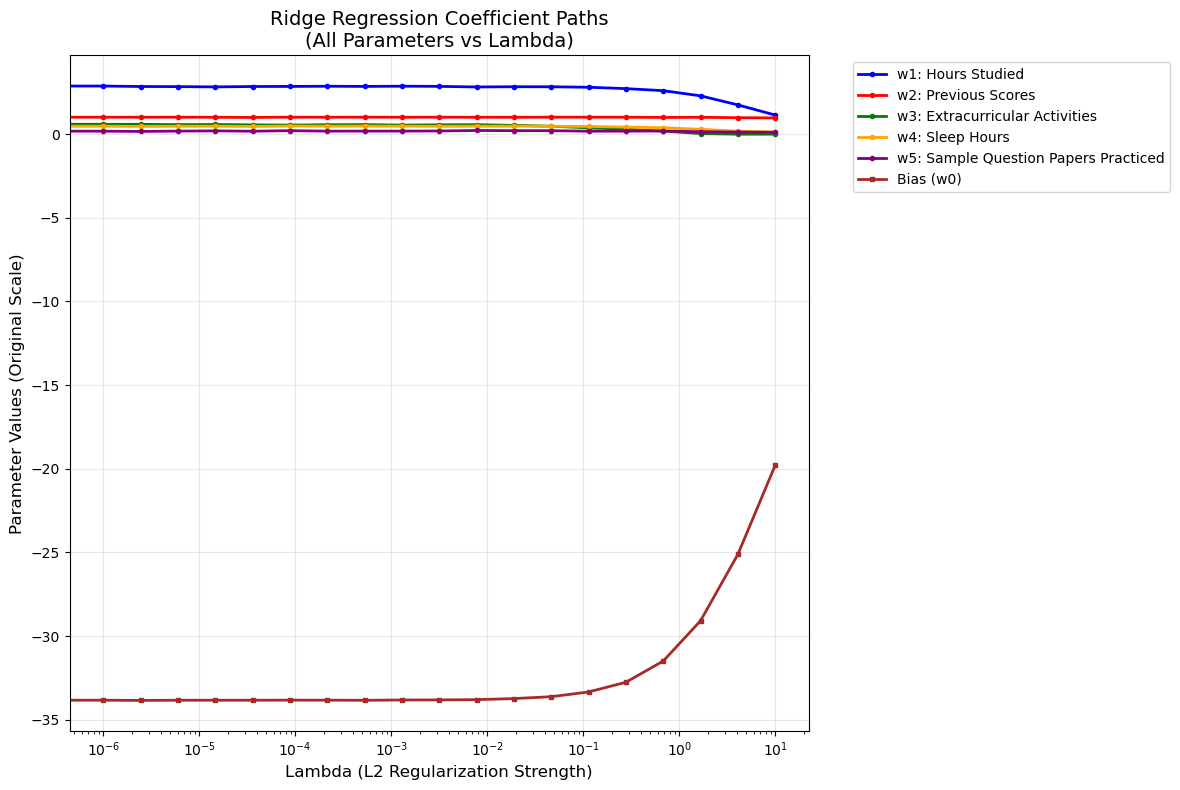

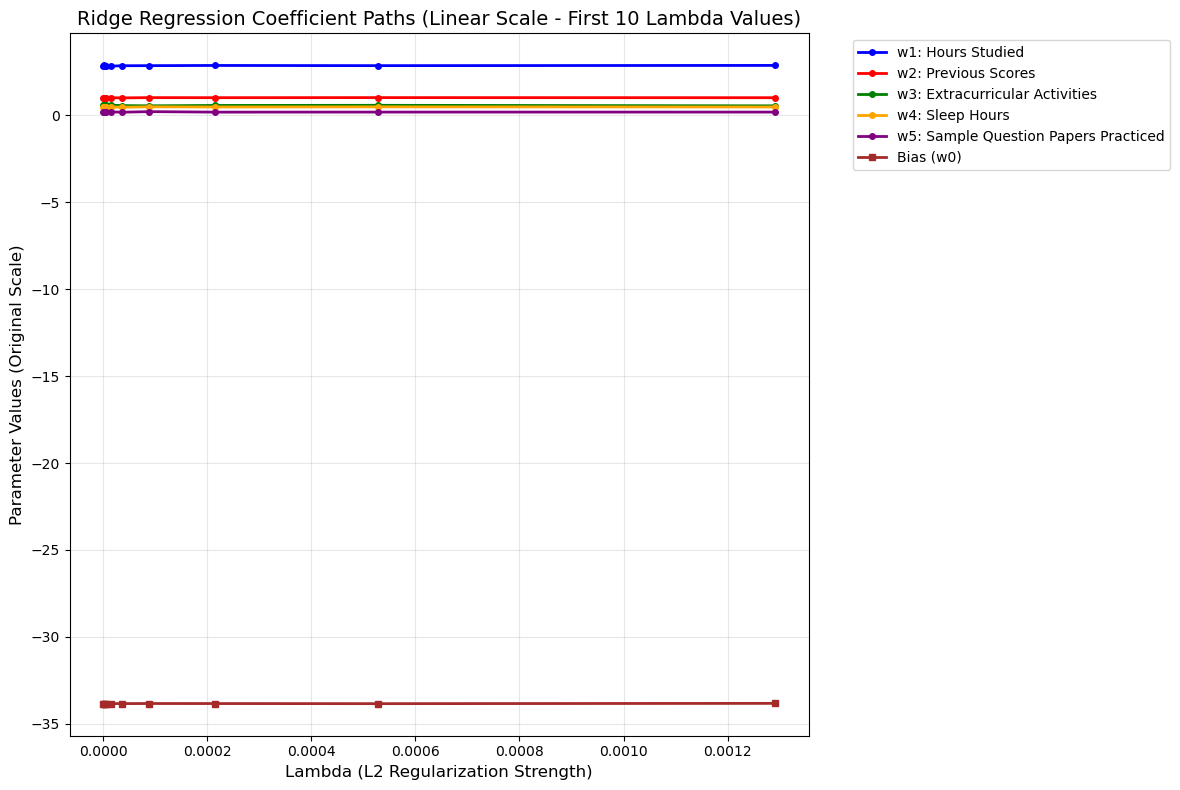

In [5]:
def betas_on_original_scale(model, normalizer=None):
    dense = next(l for l in model.layers if isinstance(l, tf.keras.layers.Dense))
    W, b = dense.get_weights()         # W: (n_features,1)
    W = W[:,0]
    if normalizer is None:
        return W, float(b)
    means = normalizer.get_mean().numpy()
    stds  = np.sqrt(normalizer.get_variance().numpy())
    beta  = W / stds
    beta0 = b - np.sum(means * beta)
    return beta, float(beta0)

def build_model(lambda_l2, n_feats, normalizer=None):
    inp = keras.Input(shape=(n_feats,))
    x = inp if normalizer is None else normalizer(inp)
    out = keras.layers.Dense(1, activation=None,
                             kernel_regularizer=keras.regularizers.l2(lambda_l2))(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(1e-2), loss="mse")
    return m

lams = np.concatenate([[0], np.logspace(-6, 1, 19)])  # Start with 0, then exponential spacing
coef_paths = []
bias_paths = []

for lam in lams:
    model_lam = build_model(lam, X_train.shape[1], normalizer=None)
    model_lam.fit(X_train, y_train, epochs=200, batch_size=32,
                  validation_data=(X_val, y_val), verbose=0)
    betas, bias = betas_on_original_scale(model_lam, normalizer=None)
    coef_paths.append(betas)
    bias_paths.append(bias)

coef_paths = np.array(coef_paths)  # shape: (n_lams, n_features)
bias_paths = np.array(bias_paths)  # shape: (n_lams,)

# Create a single plot with all 6 parameters
plt.figure(figsize=(12, 8))

# Define colors for each line
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

# Plot coefficients for each feature
for j, name in enumerate(feature_names):
    plt.plot(lams, coef_paths[:, j], color=colors[j], linewidth=2, 
             label=f'w{j+1}: {name}', marker='o', markersize=3)

# Plot bias term
plt.plot(lams, bias_paths, color=colors[5], linewidth=2, 
         label='Bias (w0)', marker='s', markersize=3)

plt.xscale("log")
plt.xlabel("Lambda (L2 Regularization Strength)", fontsize=12)
plt.ylabel("Parameter Values (Original Scale)", fontsize=12)
plt.title("Ridge Regression Coefficient Paths\n(All Parameters vs Lambda)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Also create a linear scale version to better see the lambda=0 point
plt.figure(figsize=(12, 8))

# Plot the first few lambda values on linear scale to better see the OLS point
lams_subset = lams[:10]  # First 10 lambda values including 0
coef_subset = coef_paths[:10]
bias_subset = bias_paths[:10]

for j, name in enumerate(feature_names):
    plt.plot(lams_subset, coef_subset[:, j], color=colors[j], linewidth=2, 
             label=f'w{j+1}: {name}', marker='o', markersize=4)

plt.plot(lams_subset, bias_subset, color=colors[5], linewidth=2, 
         label='Bias (w0)', marker='s', markersize=4)

plt.xlabel("Lambda (L2 Regularization Strength)", fontsize=12)
plt.ylabel("Parameter Values (Original Scale)", fontsize=12)
plt.title("Ridge Regression Coefficient Paths (Linear Scale - First 10 Lambda Values)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
    

mean(y_train): 55.399715423583984
bias at largest λ: -19.79292869567871


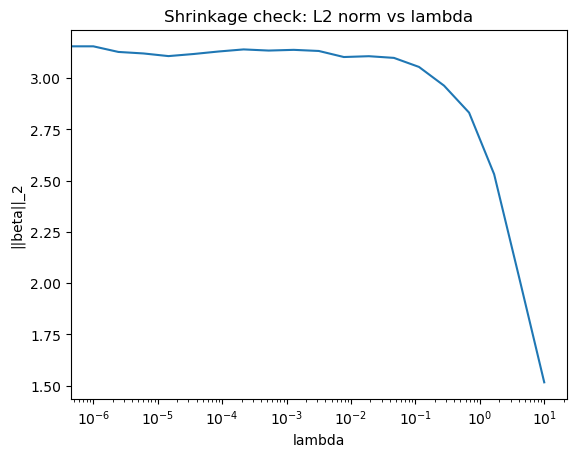

std(yhat)  at small λ: 18.992565155029297
std(yhat)  at large λ: 17.17828941345215
std(y_test)           : 19.179401397705078


In [17]:
# 1) Intercept should approach mean(y_train) as λ → large
print("mean(y_train):", float(np.mean(y_train)))
print("bias at largest λ:", float(bias_paths[-1]))

# 2) Overall shrinkage: ||β||₂ should decrease as λ increases
beta_norm = np.linalg.norm(coef_paths, axis=1)  # one norm per lambda
plt.figure(); plt.plot(lams, beta_norm); plt.xscale("log")
plt.xlabel("lambda"); plt.ylabel("||beta||_2")
plt.title("Shrinkage check: L2 norm vs lambda"); plt.show()

# 3) Predictions collapse toward the mean at large λ
yhat_small = (coef_paths[0] @ X_test.T) + bias_paths[0]   # approx if features are in same order
yhat_large = (coef_paths[-1] @ X_test.T) + bias_paths[-1]
print("std(yhat)  at small λ:", float(np.std(yhat_small)))
print("std(yhat)  at large λ:", float(np.std(yhat_large)))
print("std(y_test)           :", float(np.std(y_test)))


# Multilinear Regression with Ridge, Lasso, and Elastic Net (TensorFlow/Keras)

**Notebook generated:** 2025-09-20 05:40:23

This notebook shows how to:
- Train a **multilinear regression** model with TensorFlow/Keras.
- Add **ridge (L2)**, **lasso (L1)**, or **elastic net (L1+L2)** regularization.
- Use a **Normalization** layer (subtract mean, divide by std) that lives inside the model.
- Evaluate with metrics and visualize:
  - Training curves
  - Predicted vs Actual
  - Residuals + histogram
  - Coefficient bars (on original units)
  - **Permutation importance**
  - **Coefficient paths** vs regularization strength (ridge / elastic net)

> If you have the Kaggle *Student Performance (Multiple Linear Regression)* dataset, set the `CSV_PATH` below to your file path (e.g., `"Student_Performance.csv"`).  
> If the file isn't found, the notebook will generate a small **synthetic** dataset with similar columns so you can run all cells.


In [6]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


TensorFlow: 2.18.1
NumPy: 2.0.2
Pandas: 2.3.2



## 1) Load Data

- Set `CSV_PATH` to your **local** CSV if available (e.g., `Student_Performance.csv`).  
- The notebook expects columns:  
  `Hours Studied`, `Previous Scores`, `Extracurricular Activities` (0/1 or Yes/No), `Sleep Hours`, `Sample Question Papers Practiced`, and target `Performance Index`.

If the file isn't found, we'll create a **synthetic** dataset with the same column names for demonstration.


In [7]:

path = os.environ["DATA_PATH"]

files = os.listdir(path)
csv_files = [f for f in files if f.endswith('.csv')]

csv_file = csv_files[0]
csv_path = os.path.join(path, csv_file)
df = pd.read_csv(csv_path)

# If Extracurricular Activities is 'Yes'/'No', convert to 1/0:
if df["Extracurricular Activities"].dtype == object:
    df["Extracurricular Activities"] = df["Extracurricular Activities"].str.strip().str.lower().map({"yes":1, "no":0})


print(f"Loaded {csv_file}")
display(df.head())
print("Describe:"); display(df.describe(include="all"))


Loaded Student_Performance.csv


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


Describe:


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000



## 2) Prepare splits and tensors
We'll make **train/validation/test** splits and ensure everything is `float32`.


In [8]:

#  Basic cleaning / column selection
target = "Performance Index"
features = [
    "Hours Studied",
    "Previous Scores",
    "Extracurricular Activities",   # often 0/1
    "Sleep Hours",
    "Sample Question Papers Practiced"
]

X = df[features].astype("float32")
y = df[target].astype("float32")



X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shapes:")
print(" X_train:", X_train.shape, " y_train:", y_train.shape)
print(" X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print(" X_test: ", X_test.shape,  " y_test: ", y_test.shape)


Shapes:
 X_train: (7000, 5)  y_train: (7000,)
 X_val:   (1500, 5)  y_val:   (1500,)
 X_test:  (1500, 5)  y_test:  (1500,)



## 3) Helper functions
- Model builders for **Ridge/Lasso/Elastic Net** (with a `Normalization` layer).
- Weight extraction on **original feature units**.
- Visualization utilities and **permutation importance**.
- Coefficient **path** plots vs regularization.


In [15]:

def build_linear_model_with_regularization(X_train_np, l1=0.0, l2=0.0, lr=1e-2):
    """Builds a 1-unit Dense linear model with a Normalization layer (adapted on X_train_np).
    Returns (model, normalizer)."""
    normalizer = layers.Normalization()
    normalizer.adapt(X_train_np)

    inputs = keras.Input(shape=(X_train_np.shape[1],))
    x = normalizer(inputs)
    outputs = layers.Dense(
        1, activation=None,
        kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)
    )(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss="mse",
                  metrics=[keras.metrics.MeanAbsoluteError(name="mae"),
                           keras.metrics.MeanSquaredError(name="mse")])
    return model, normalizer

def get_betas_on_original_scale(model, normalizer):
    """Return (beta, beta0) where beta is on ORIGINAL feature scales."""
    dense = next(l for l in model.layers if isinstance(l, layers.Dense))
    W, b = dense.get_weights()  # W: (n_features,1)  b: (1,)
    W = W[:, 0]

    means = normalizer.mean.numpy()
    stds  = np.sqrt(normalizer.variance.numpy())

    beta = W / stds
    beta0 = b[0] - np.sum(means * beta)
    return beta, float(beta0)

def print_metrics(y_true, y_pred, prefix="Test"):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    print(f"{prefix} -> R^2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    return r2, mae, rmse

# ---- Plotting utilities (each chart in its own figure; no seaborn; no forced colors) ----

def plot_training_curves(history):
    h = history.history
    # Loss
    plt.figure()
    plt.plot(h.get("loss", []), label="loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Curve: Loss"); plt.legend()
    plt.show()
    # MAE
    if "mae" in h or "val_mae" in h:
        plt.figure()
        if "mae" in h: plt.plot(h["mae"], label="mae")
        if "val_mae" in h: plt.plot(h["val_mae"], label="val_mae")
        plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.title("Training Curve: MAE"); plt.legend()
        plt.show()

def plot_pred_vs_actual(y_true, y_pred, title_prefix="Test"):
    y_true = np.asarray(y_true).squeeze()
    y_pred = np.asarray(y_pred).squeeze()
    lo, hi = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    r2 = r2_score(y_true, y_pred)
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([lo, hi], [lo, hi], linewidth=2)
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.title(f"{title_prefix} Predicted vs Actual (R^2 = {r2:.3f})")
    plt.xlim(lo, hi); plt.ylim(lo, hi)
    plt.show()

def plot_residuals(y_true, y_pred, title_prefix="Test"):
    y_true = np.asarray(y_true).squeeze()
    y_pred = np.asarray(y_pred).squeeze()
    resid = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, resid, alpha=0.7)
    plt.axhline(0.0, linewidth=2)
    plt.xlabel("Fitted (Predicted)"); plt.ylabel("Residual")
    plt.title(f"{title_prefix} Residuals vs Fitted")
    plt.show()

    plt.figure()
    plt.hist(resid, bins=20)
    plt.xlabel("Residual"); plt.ylabel("Count")
    plt.title(f"{title_prefix} Residuals Histogram")
    plt.show()

def plot_coefficients(beta, feature_names, beta0):
    plt.figure()
    idx = np.arange(len(beta))
    plt.bar(idx, beta)
    plt.xticks(idx, feature_names, rotation=45, ha="right")
    plt.ylabel("Coefficient (original units)")
    plt.title(f"Linear Coefficients (Intercept = {beta0:.3f})")
    plt.tight_layout()
    plt.show()

def permutation_importance(model, X, y, n_repeats=10, random_state=42):
    rng = np.random.default_rng(random_state)
    X = np.asarray(X).copy()
    y = np.asarray(y).squeeze()
    base_pred = model.predict(X, verbose=0).squeeze()
    base_mae = mean_absolute_error(y, base_pred)

    deltas = []
    for j in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            Xp = X.copy()
            rng.shuffle(Xp[:, j])
            pred = model.predict(Xp, verbose=0).squeeze()
            scores.append(mean_absolute_error(y, pred) - base_mae)
        deltas.append(np.mean(scores))
    return np.array(deltas)  # per-feature ΔMAE

def plot_permutation_importance(delta_mae, feature_names):
    order = np.argsort(-delta_mae)
    names_sorted = np.array(feature_names)[order]
    vals_sorted = delta_mae[order]

    plt.figure()
    plt.bar(np.arange(len(vals_sorted)), vals_sorted)
    plt.xticks(np.arange(len(vals_sorted)), names_sorted, rotation=45, ha="right")
    plt.ylabel("ΔMAE (higher = more important)")
    plt.title("Permutation importance (test set)")
    plt.tight_layout()
    plt.show()

# ---- Coefficient paths ----
def ridge_paths(X_train_np, y_train_np, X_val_np, y_val_np, feature_names,
                lambdas=np.logspace(-6, 1, 12), epochs=200):
    paths = []
    for lam in lambdas:
        model, norm = build_linear_model_with_regularization(X_train_np, l1=0.0, l2=lam, lr=1e-2)
        hist = model.fit(X_train_np, y_train_np, epochs=epochs, batch_size=32,
                         validation_data=(X_val_np, y_val_np), verbose=0)
        beta, _ = get_betas_on_original_scale(model, norm)
        paths.append(beta)
    paths = np.array(paths)  # (n_lambdas, n_features)
    # Plot one figure with multiple lines (one per feature)
    plt.figure()
    for j, name in enumerate(feature_names):
        plt.plot(lambdas, paths[:, j], label=name)
    plt.xscale("log")
    plt.xlabel("lambda (L2 strength)"); plt.ylabel("Coefficient (original units)")
    plt.title("Ridge: Coefficient paths vs lambda"); plt.legend(); plt.tight_layout(); plt.show()

def enet_paths_over_l1(X_train_np, y_train_np, X_val_np, y_val_np, feature_names,
                       l2_fixed=1e-3, l1_grid=np.logspace(-6, -1, 12), epochs=250):
    paths = []
    nz_counts = []
    for a1 in l1_grid:
        model, norm = build_linear_model_with_regularization(X_train_np, l1=a1, l2=l2_fixed, lr=1e-2)
        hist = model.fit(X_train_np, y_train_np, epochs=epochs, batch_size=32,
                         validation_data=(X_val_np, y_val_np), verbose=0)
        beta, _ = get_betas_on_original_scale(model, norm)
        paths.append(beta)
        nz_counts.append((np.abs(beta) > 1e-6).sum())
    paths = np.array(paths)
    nz_counts = np.array(nz_counts)

    # Coefficient paths
    plt.figure()
    for j, name in enumerate(feature_names):
        plt.plot(l1_grid, paths[:, j], label=name)
    plt.xscale("log")
    plt.xlabel("L1 strength (alpha1)"); plt.ylabel("Coefficient (original units)")
    plt.title(f"Elastic Net: Coefficient paths vs L1 (L2 fixed={l2_fixed})")
    plt.legend(); plt.tight_layout(); plt.show()

    # Sparsity curve
    plt.figure()
    plt.plot(l1_grid, nz_counts)
    plt.xscale("log")
    plt.xlabel("L1 strength (alpha1)"); plt.ylabel("# non-zero coefficients")
    plt.title("Elastic Net: sparsity vs L1"); plt.tight_layout(); plt.show()



## 4) Ridge (L2) demo
Train a ridge-regularized linear model, evaluate, and visualize.


In [ ]:

# Build & train Ridge model
l2_strength = 1e-3
ridge_model, ridge_norm = build_linear_model_with_regularization(X_train.to_numpy(), l1=0.0, l2=l2_strength, lr=1e-2)
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
ridge_hist = ridge_model.fit(X_train, y_train, epochs=400, batch_size=32,
                             validation_data=(X_val, y_val), callbacks=[es], verbose=0)

# Evaluate
y_pred_test = ridge_model.predict(X_test, verbose=0).squeeze()
print_metrics(y_test, y_pred_test)

# Coefficients on original scale
beta_ridge, beta0_ridge = get_betas_on_original_scale(ridge_model, ridge_norm)
print("\nRidge coefficients (original units):")
for name, b in zip(features, beta_ridge):
    print(f"  {name} {b}")
print("Intercept:", beta0_ridge)

# Visuals
plot_training_curves(ridge_hist)
plot_pred_vs_actual(y_test, y_pred_test, title_prefix="Ridge Test")
plot_residuals(y_test, y_pred_test, title_prefix="Ridge Test")
plot_coefficients(beta_ridge, features, beta0_ridge)

# Permutation importance
delta = permutation_importance(ridge_model, X_test, y_test, n_repeats=10, random_state=42)
plot_permutation_importance(delta, features)


Test -> R^2: 0.9888 | MAE: 1.6161 | RMSE: 4.1017

Ridge coefficients (original units):


TypeError: unsupported format string passed to numpy.ndarray.__format__


## 5) Lasso (L1) demo
Same pipeline but with L1 regularization (can drive some coefficients to **exactly zero**).


In [ ]:

l1_strength = 1e-3
lasso_model, lasso_norm = build_linear_model_with_regularization(X_train.to_numpy(), l1=l1_strength, l2=0.0, lr=1e-2)
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
lasso_hist = lasso_model.fit(X_train, y_train, epochs=400, batch_size=32,
                             validation_data=(X_val, y_val), callbacks=[es], verbose=0)

y_pred_test_l1 = lasso_model.predict(X_test, verbose=0).squeeze()
print_metrics(y_test, y_pred_test_l1, prefix="Lasso Test")

beta_lasso, beta0_lasso = get_betas_on_original_scale(lasso_model, lasso_norm)
print("\nLasso coefficients (original units):")
for name, b in zip(features, beta_lasso):
    print(f"  {name} {b}")
print("Intercept:", beta0_lasso)

plot_training_curves(lasso_hist)
plot_pred_vs_actual(y_test, y_pred_test_l1, title_prefix="Lasso Test")
plot_residuals(y_test, y_pred_test_l1, title_prefix="Lasso Test")
plot_coefficients(beta_lasso, features, beta0_lasso)



## 6) Elastic Net (L1 + L2) demos
- **Coefficient paths** as L2 varies (ridge) or as L1 varies (elastic net with L2 fixed).  
- A tiny **grid search** over (L1, L2) by validation MAE to pick a good combo.


In [ ]:

# Coefficient paths: Ridge
ridge_paths(X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy(),
            feature_names=features, lambdas=np.logspace(-6, 1, 10), epochs=200)

# Coefficient paths over L1 with fixed L2 (Elastic Net)
enet_paths_over_l1(X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy(),
                   feature_names=features, l2_fixed=1e-3, l1_grid=np.logspace(-6, -1, 10), epochs=200)


In [ ]:

# Tiny grid search for Elastic Net by validation MAE
grid_l1 = np.logspace(-6, -2, 5)
grid_l2 = np.logspace(-6, -2, 5)

best = {"mae": float("inf")}
for a1 in grid_l1:
    for a2 in grid_l2:
        m, norm = build_linear_model_with_regularization(X_train.to_numpy(), l1=a1, l2=a2, lr=1e-2)
        hist = m.fit(X_train, y_train, epochs=250, batch_size=32,
                     validation_data=(X_val, y_val), verbose=0)
        val_mae = min(hist.history["val_mae"])
        if val_mae < best["mae"]:
            best = {"mae": val_mae, "l1": a1, "l2": a2, "model": m, "norm": norm}

print(f"Best val MAE: {best['mae']:.4f} at l1={best['l1']:.2e}, l2={best['l2']:.2e}")
beta_best, b0_best = get_betas_on_original_scale(best["model"], best["norm"])
print("\nElastic Net best-model coefficients (original units):")
for name, b in zip(features, beta_best):
    print(f"  {name} {b}")
print("Intercept:", b0_best)

# Test performance of best ENet
y_pred_best = best["model"].predict(X_test, verbose=0).squeeze()
print_metrics(y_test, y_pred_best, prefix="Elastic Net (best) Test")
plot_pred_vs_actual(y_test, y_pred_best, title_prefix="Elastic Net (best) Test")
plot_residuals(y_test, y_pred_best, title_prefix="Elastic Net (best) Test")
plot_coefficients(beta_best, features, b0_best)



## 7) Predicting new rows
Pass raw feature values in the **same order** used for training. If your model includes the `Normalization` layer (it does), no external scaling is needed.


In [ ]:

def predict_one(model, sample_dict, feature_order):
    row = []
    for f in feature_order:
        v = sample_dict[f]
        if f == "Extracurricular Activities" and isinstance(v, str):
            v = 1.0 if v.strip().lower() == "yes" else 0.0
        row.append(float(v))
    x = np.array([row], dtype="float32")
    return float(model.predict(x, verbose=0)[0,0])

example_row = {
    "Hours Studied": 5,
    "Previous Scores": 78,
    "Extracurricular Activities": 1,
    "Sleep Hours": 7,
    "Sample Question Papers Practiced": 10
}

print("Example prediction with Ridge model:", predict_one(ridge_model, example_row, features))



## 8) Save and load the model
Saving keeps the **Normalization** + weights together for consistent future inference.


In [ ]:

ridge_model.save("ridge_linear_model.keras")
print("Saved ridge model to ridge_linear_model.keras")

# Reload and test a quick prediction
reloaded = keras.models.load_model("ridge_linear_model.keras")
print("Reloaded prediction:", predict_one(reloaded, example_row, features))



## 9) Feature importance bar graphs (per model)

Below we show **two** importance views for each model (**Ridge**, **Lasso**, and the best **Elastic Net**):

1. **|Standardized coefficient|** — scale-invariant effect size (per 1 SD change).  
   - If a `Normalization` layer is inside the model, the Dense weights already correspond to standardized inputs, so we take `abs(weights)`.
   - If no normalizer were used, we’d multiply by the training std of each feature to get comparable magnitudes.

2. **Permutation importance (ΔMAE)** — how much the **test MAE** gets worse when we randomly shuffle a feature (higher = more important in prediction).  
   This reflects *actual predictive impact* and helps when features are correlated.

> Rankings may differ when predictors are correlated. In that case, trust **permutation importance** more for prediction, while coefficient magnitudes remain helpful for interpretability.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def _first_dense(model):
    return next(l for l in model.layers if isinstance(l, tf.keras.layers.Dense))

def standardized_coef_importance(model, X_train, feature_names, normalizer=None):
    """Return (names_sorted, importances_sorted) using |standardized coefficients|."""
    dense = _first_dense(model)
    W, _ = dense.get_weights()           # W: (n_features, 1)
    W = W[:, 0]
    if normalizer is not None:
        imp = np.abs(W)                  # already per-1SD inputs
    else:
        Xn = np.asarray(X_train)
        stds = Xn.std(axis=0, ddof=0)
        imp = np.abs(W * stds)           # scale to 1SD effect
    order = np.argsort(-imp)
    return np.array(feature_names)[order], imp[order]

def permutation_importance(model, X, y, n_repeats=10, random_state=42):
    rng = np.random.default_rng(random_state)
    X = np.asarray(X).copy()
    y = np.asarray(y).squeeze()
    base_pred = model.predict(X, verbose=0).squeeze()
    from sklearn.metrics import mean_absolute_error
    base_mae = mean_absolute_error(y, base_pred)

    deltas = []
    for j in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            Xp = X.copy()
            rng.shuffle(Xp[:, j])
            pred = model.predict(Xp, verbose=0).squeeze()
            scores.append(mean_absolute_error(y, pred) - base_mae)
        deltas.append(np.mean(scores))
    return np.array(deltas)

def feature_importance_bars(model, normalizer, X_train, X_test, y_test, feature_names, title_prefix):
    # 1) Coefficient-based (standardized)
    names_c, vals_c = standardized_coef_importance(model, X_train, feature_names, normalizer)
    plt.figure()
    plt.bar(np.arange(len(vals_c)), vals_c)
    plt.xticks(np.arange(len(vals_c)), names_c, rotation=45, ha="right")
    plt.ylabel("|standardized coefficient|")
    plt.title(f"{title_prefix}: coefficient importance")
    plt.tight_layout()
    plt.show()

    # 2) Permutation importance (ΔMAE)
    deltas = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    order = np.argsort(-deltas)
    names_p = np.array(feature_names)[order]
    vals_p = deltas[order]
    plt.figure()
    plt.bar(np.arange(len(vals_p)), vals_p)
    plt.xticks(np.arange(len(vals_p)), names_p, rotation=45, ha="right")
    plt.ylabel("ΔMAE (higher = more important)")
    plt.title(f"{title_prefix}: permutation importance (test)")
    plt.tight_layout()
    plt.show()

# ---- Run for each trained model ----
feature_importance_bars(ridge_model, ridge_norm, X_train, X_test, y_test, features, "Ridge")
feature_importance_bars(lasso_model, lasso_norm, X_train, X_test, y_test, features, "Lasso")

# Elastic Net "best" was created in section 6; guard in case user skipped that cell.
try:
    feature_importance_bars(best["model"], best["norm"], X_train, X_test, y_test, features, "Elastic Net (best)")
except Exception as e:
    print("Elastic Net 'best' model not available yet. Run section 6 first.\n", e)
